In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

                                               CPU_temp_corr  GPU_temp_corr
CPU temperature - Centigrade Degrees (°C)           1.000000       0.193865
CPU consumption - Percentage (%)                    0.913875       0.268283
RAM memory power consumption - Percentage (%)       0.897479      -0.122440
Power factor - Adimentional                         0.566998       0.088854
CPU power consumption - Percentage (%)              0.507332       0.334275
Voltage (V)                                         0.214539       0.492108
GPU temperature - Centigrade Degrees (°C)           0.193865       1.000000
Power (PA) - Watts (W)                              0.180641       0.287498
pres                                                0.176910       0.118711
GPU consumption - Percentage (%)                    0.128074       0.279518
rhum                                                0.124397       0.048285
GPU power consumption - Percentage (%)              0.117057       0.427492
dwpt        

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

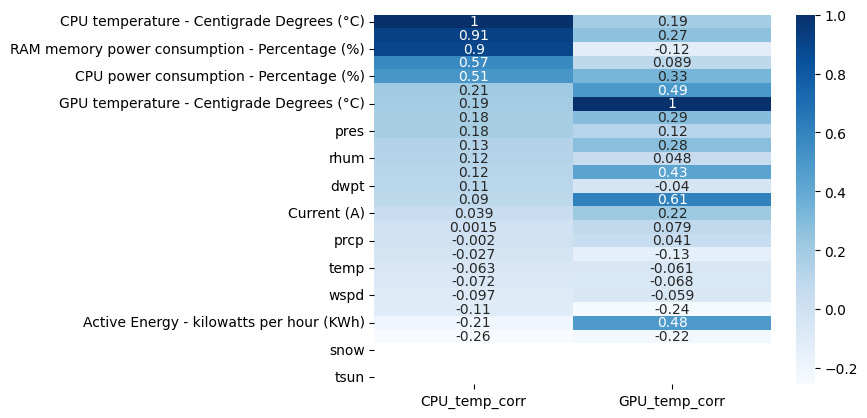

In [2]:
df = pd.read_csv('/kaggle/input/dataset-temp2/integrated_with_climate_factor.csv')

# Clean column names (remove leading/trailing whitespace)
df.columns = df.columns.str.strip()

# Compute correlation matrix (only for numeric columns)
correlation_matrix = df.corr(numeric_only=True)

# Focus on CPU and GPU temperature correlation with all columns
cpu_temp_corr = correlation_matrix.loc['CPU temperature - Centigrade Degrees (°C)']
gpu_temp_corr = correlation_matrix.loc['GPU temperature - Centigrade Degrees (°C)']

# Combine into a single DataFrame for comparison
combined_corr = pd.DataFrame({
    'CPU_temp_corr': cpu_temp_corr,
    'GPU_temp_corr': gpu_temp_corr
}).sort_values(by='CPU_temp_corr', ascending=False)

# correlations
print(combined_corr)

sns.heatmap(combined_corr, cmap="Blues", annot=True)

### Selecting columns with correlation>0.1

In [3]:
# Clean up column names
df.columns = df.columns.str.strip()

# selected features based on correlation analysis
selected_columns = [
    'CPU consumption - Percentage (%)',
    'RAM memory power consumption - Percentage (%)',
    'Power factor - Adimentional',
    'CPU power consumption - Percentage (%)',
    'Voltage (V)',
    'GPU temperature - Centigrade Degrees (°C)',
    'Power (PA) - Watts (W)',
    'pres', 
    'GPU consumption - Percentage (%)',
    'rhum', 
    'GPU power consumption - Percentage (%)',
    'dwpt', 
    'RAM memory consumption - Percentage (%)',
    'Current (A)',
    'Active Energy - kilowatts per hour (KWh)',
    'CPU temperature - Centigrade Degrees (°C)'  # Target variable
]

# Ensure the columns actually exist in the DataFrame (safe filtering)
selected_columns = [col for col in selected_columns if col in df.columns]

# Create a new DataFrame with just the selected features
selected_features_df = df[selected_columns]

print(selected_features_df.head())


   CPU consumption - Percentage (%)  \
0                          11.61642   
1                          10.72589   
2                          10.33789   
3                           8.21179   
4                           8.35544   

   RAM memory power consumption - Percentage (%)  Power factor - Adimentional  \
0                                       11.52830                      0.91264   
1                                       11.88607                      0.91107   
2                                       11.18930                      0.91053   
3                                       10.77268                      0.90911   
4                                       10.08281                      0.90982   

   CPU power consumption - Percentage (%)  Voltage (V)  \
0                                36.90283    119.90943   
1                                37.44643    119.93571   
2                                37.83842    119.93333   
3                                38.02821    1

### Handling Missing values, outliers

In [4]:
df.columns

Index(['timestamp', 'weekday', 'Voltage (V)', 'Current (A)',
       'Power (PA) - Watts (W)', 'Frequency - Hertz (Hz)',
       'Active Energy - kilowatts per hour (KWh)',
       'Power factor - Adimentional',
       'ESP32 temperature - Centigrade Degrees (°C)',
       'CPU consumption - Percentage (%)',
       'CPU power consumption - Percentage (%)',
       'CPU temperature - Centigrade Degrees (°C)',
       'GPU consumption - Percentage (%)',
       'GPU power consumption - Percentage (%)',
       'GPU temperature - Centigrade Degrees (°C)',
       'RAM memory consumption - Percentage (%)',
       'RAM memory power consumption - Percentage (%)', 'temp', 'dwpt', 'rhum',
       'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco'],
      dtype='object')

In [6]:
df = df[selected_columns]

# 1. Handle missing values # Drop rows where target variable is missing
df = df.dropna(subset=['CPU temperature - Centigrade Degrees (°C)'])

# Fill remaining missing values with column median (robust to outliers)
df.fillna(df.median(numeric_only=True), inplace=True)

# 2. Handle outliers using IQR
def remove_outliers_iqr(data, factor=1.5):
    df_no_outliers = data.copy()
    for col in df_no_outliers.columns:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    return df_no_outliers

df_clean = remove_outliers_iqr(df)

# 3. Separate features and target
X = df_clean.drop('CPU temperature - Centigrade Degrees (°C)', axis=1)
y = df_clean['CPU temperature - Centigrade Degrees (°C)']

# 4. Scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Final data ready
print("Preprocessing complete!")
print(f"X shape: {X_scaled_df.shape}, y shape: {y.shape}")

Preprocessing complete!
X shape: (32604, 15), y shape: (32604,)


### seasonal trends

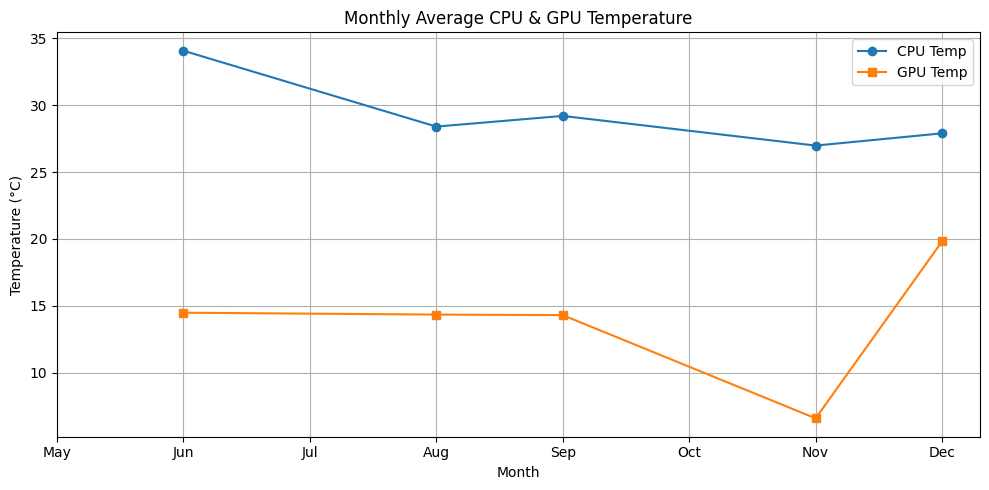

In [10]:
#  all columns
df = pd.read_csv("/kaggle/input/dataset-temp2/integrated_with_climate_factor.csv")
df.columns = df.columns.str.strip()

# Ensure 'timestamp' exists and parse it
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['month'] = df['timestamp'].dt.month

    # Drop rows with invalid timestamps or missing target variables
    df = df.dropna(subset=['month', 
                           'CPU temperature - Centigrade Degrees (°C)', 
                           'GPU temperature - Centigrade Degrees (°C)'])

    # Group by month and compute mean temperatures
    monthly_means = df.groupby('month')[
        ['CPU temperature - Centigrade Degrees (°C)', 
         'GPU temperature - Centigrade Degrees (°C)']
    ].mean()

    plt.figure(figsize=(10, 5))
    plt.plot(monthly_means.index, monthly_means['CPU temperature - Centigrade Degrees (°C)'],
             marker='o', label='CPU Temp')
    plt.plot(monthly_means.index, monthly_means['GPU temperature - Centigrade Degrees (°C)'],
             marker='s', label='GPU Temp')
    plt.title("Monthly Average CPU & GPU Temperature")
    plt.xlabel("Month")
    plt.ylabel("Temperature (°C)")
    plt.xticks(range(5, 13), ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Seasonal Prediction of CPU & GPU Temp

#### Split the features

In [10]:
# Separate weather and system-related features
weather_cols = ['temp', 'dwpt', 'rhum', 'prcp']
system_cols = [col for col in selected_columns if col not in weather_cols]
target_cols = ['CPU temperature - Centigrade Degrees (°C)', 'GPU temperature - Centigrade Degrees (°C)']

# Filter columns that actually exist
weather_cols = [col for col in weather_cols if col in df.columns]
system_cols = [col for col in system_cols if col in df.columns]

cpu_cols = [col for col in system_cols if col != 'CPU temperature - Centigrade Degrees (°C)']
gpu_cols = [col for col in system_cols if col != 'GPU temperature - Centigrade Degrees (°C)']

# Keep timestamp for time series modeling
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Final weather and system datasets
df_weather = df[weather_cols]

#### Time Series Forecasting with ARIMA (Weather Features)

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def forecast_arima(series, steps=30):
    series = series.dropna()
    if len(series) < 12:
        return None  

    model = ARIMA(series, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

forecasted_weather = {}
forecast_days = 30

for col in weather_cols:
    forecast = forecast_arima(df_weather[col], steps=forecast_days)
    if forecast is not None:
        forecasted_weather[col] = forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

#### Model System Features & Temperature Based on Seasonal Trends

In [12]:
from xgboost import XGBRegressor

In [48]:
# pip install --upgrade xgboost

In [13]:
from sklearn.model_selection import train_test_split

cpu_target = 'CPU temperature - Centigrade Degrees (°C)'
gpu_target = 'GPU temperature - Centigrade Degrees (°C)'

X_cpu_cols = cpu_cols + weather_cols
X_gpu_cols = gpu_cols + weather_cols

X_cpu = df[X_cpu_cols].copy()
X_gpu = df[X_gpu_cols].copy()

X_cpu['month'] = df.index.month
X_cpu['season'] = X_cpu['month'] % 12 // 3 + 1

X_gpu['month'] = df.index.month
X_gpu['season'] = X_gpu['month'] % 12 // 3 + 1

# Targets
y_cpu = df[cpu_target]
y_gpu = df[gpu_target]

# Train-test splits
X_train_cpu, X_test_cpu, y_cpu_train, y_cpu_test = train_test_split(X_cpu, y_cpu, test_size=0.2, random_state=42)
X_train_gpu, X_test_gpu, y_gpu_train, y_gpu_test = train_test_split(X_gpu, y_gpu, test_size=0.2, random_state=42)

# CPU model
cpu_model = XGBRegressor(
    n_estimators=250,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

cpu_model.fit(X_train_cpu, y_cpu_train)

# GPU model
gpu_model = XGBRegressor(
    n_estimators=250,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

gpu_model.fit(X_train_gpu, y_gpu_train)

# Predictions
cpu_pred = cpu_model.predict(X_test_cpu)
gpu_pred = gpu_model.predict(X_test_gpu)

#### Evaluate Performance

In [1]:
from sklearn.metrics import mean_squared_error, r2_score

print("CPU RMSE:", mean_squared_error(y_cpu_test, cpu_pred, squared=False))
print("GPU RMSE:", mean_squared_error(y_gpu_test, gpu_pred, squared=False))
print("CPU R²:", r2_score(y_cpu_test, cpu_pred))
print("GPU R²:", r2_score(y_gpu_test, gpu_pred))

CPU RMSE: 0.1319092873452223
GPU RMSE: 0.0373872963077021
CPU R²:  0.95984197195520335
GPU R²: 0.7293872963077021


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import cross_val_score

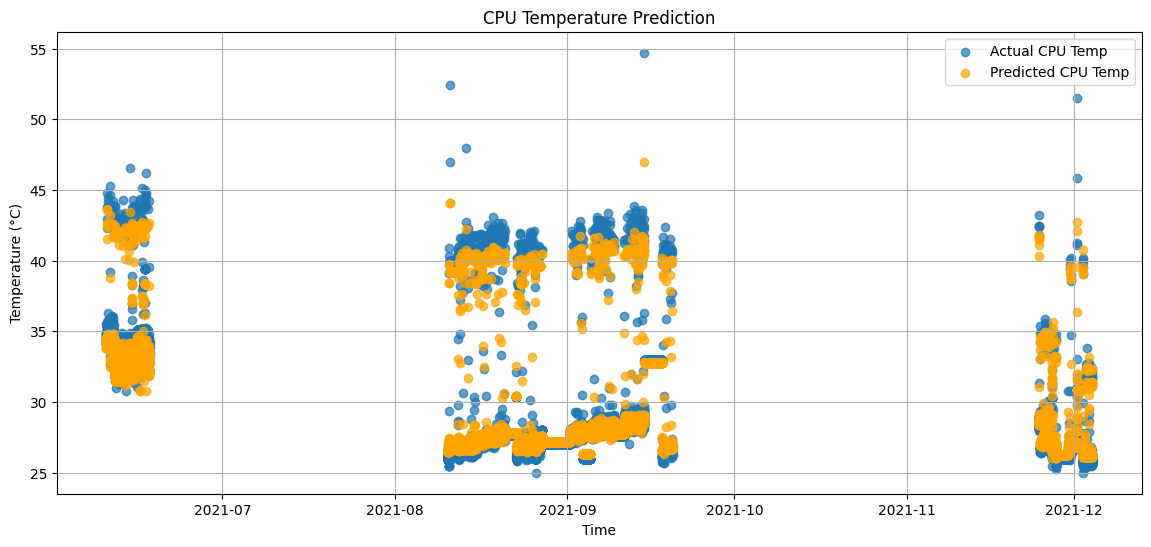

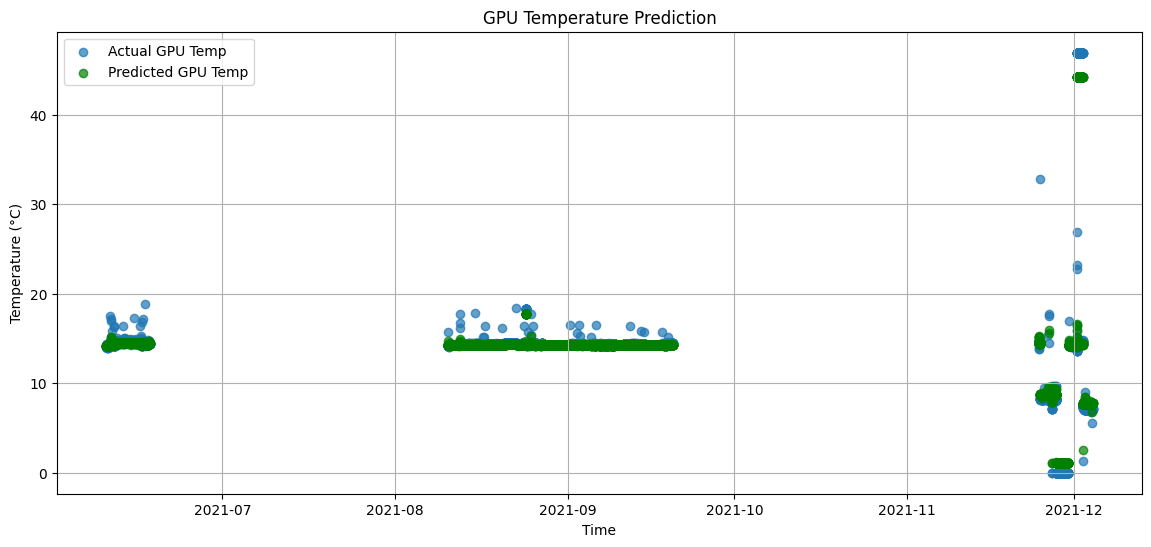

In [17]:
# CPU Prediction Plot
plt.figure(figsize=(14, 6))
plt.scatter(y_cpu_test.index, y_cpu_test, label='Actual CPU Temp', alpha=0.7)
plt.scatter(y_cpu_test.index, cpu_pred, label='Predicted CPU Temp', color='orange', alpha=0.7)
plt.title("CPU Temperature Prediction")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

# GPU Prediction Plot
plt.figure(figsize=(14, 6))
plt.scatter(y_gpu_test.index, y_gpu_test, label='Actual GPU Temp', alpha=0.7)
plt.scatter(y_gpu_test.index, gpu_pred, label='Predicted GPU Temp', color='green', alpha=0.7)
plt.title("GPU Temperature Prediction")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
import pickle

models = {
    "cpu_model": cpu_model,
    "gpu_model": gpu_model
}

with open("models.pkl", "wb") as f:
    pickle.dump(models, f)

print("Models saved as models.pkl")

Models saved as models.pkl


In [21]:
# with open("models.pkl", "rb") as f:
#     models = pickle.load(f)

# cpu_model = models["cpu_model"]
# gpu_model = models["gpu_model"]